# Ball mapper

This notebook was prepared from an original idea of [Davide Gurnari](https://github.com/dgurnari). 

## Generate data

In [164]:
using LinearAlgebra
using Plots
using Random
using Statistics

We will start by constructing a collection of points sampled from a unit circle.

In [165]:
function noisy_circle(rng, n, noise=0.05)
    x = zeros(n)
    y = zeros(n)
    for i in 1:n
        θ = 2π * rand(rng)
        x[i] = cos(θ) + 2 * noise * (rand(rng) - 0.5)
        y[i] = sin(θ) + 2 * noise * (rand(rng) - 0.5)
    end
    return vcat(x', y')
end

noisy_circle (generic function with 2 methods)

In [166]:
rng = MersenneTwister(1234)

MersenneTwister(1234)

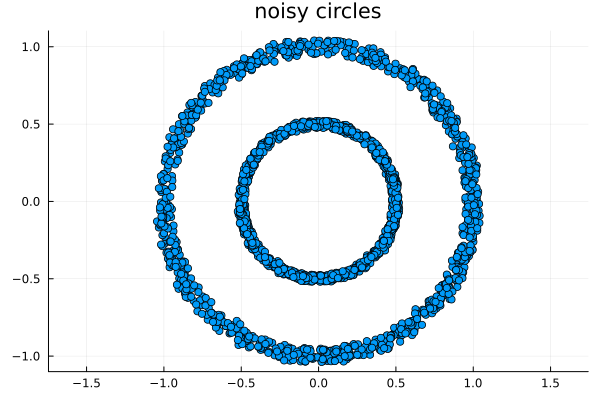

In [192]:
nc = noisy_circle(rng, 1000)
points = hcat(nc, 0.5 .* nc )
scatter(points[1,:], points[2,:]; aspect_ratio=1, legend=false, title="noisy circles")

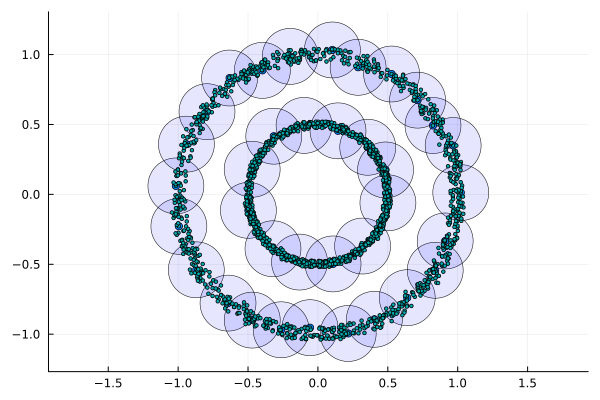

In [193]:
function find_centers( points, ϵ )
    centers = Dict{Int, Int}() # dict of points {idx_v: idx_p, ... }
    centers_counter = 1
    
    for (idx_p, p) in enumerate(eachcol(points))
        
        is_covered = false

        for idx_v in keys(centers)
            distance = norm(p .- points[:, centers[idx_v]])
            if distance <= ϵ
                is_covered = true
                break
            end
        end

        if !is_covered
            centers[centers_counter] = idx_p
            centers_counter += 1
        end
        
    end
    return centers
end
ϵ = 0.2
centers = find_centers( points, ϵ )
idxs = collect(values(centers))
scatter(points[1,idxs], points[2,idxs]; aspect_ratio=1, label="centers")
function ball(h, k, r)
    θ = LinRange(0, 2π, 500)
    h .+ r * sin.(θ), k .+ r * cos.(θ)
end
for i in idxs
    plot!(ball(points[1,i], points[2,i], ϵ), seriestype = [:shape,], lw = 0.5, c = :blue, 
            linecolor = :black, legend = false, fillalpha = 0.1, aspect_ratio = 1)
end
scatter!(points[1,:], points[2,:]; aspect_ratio=1,  label = "points", ms = 2)

In [194]:
function compute_points_covered_by_landmarks( points, centers :: Dict{Int, Int}, ϵ)
    points_covered_by_landmarks = Dict{Int,Vector{Int}}()
    for idx_v in values(centers)
        points_covered_by_landmarks[idx_v] = Int[]
        for (idx_p, p) in enumerate(eachcol(points))
            distance = norm(p .- points[:,idx_v])
            if distance <= ϵ
                push!(points_covered_by_landmarks[idx_v], idx_p)
            end
        end
    end
    return sort(points_covered_by_landmarks)
end
points_covered_by_landmarks = compute_points_covered_by_landmarks( points, centers, ϵ)

OrderedDict{Int64, Vector{Int64}} with 36 entries:
  1    => [1, 18, 19, 40, 43, 64, 101, 109, 133, 136  …  875, 878, 888, 895, 90…
  2    => [2, 14, 30, 37, 39, 60, 70, 76, 83, 96  …  911, 917, 922, 924, 925, 9…
  3    => [3, 47, 53, 54, 81, 95, 115, 138, 141, 155  …  851, 861, 873, 887, 90…
  4    => [4, 12, 16, 31, 48, 72, 87, 90, 98, 99  …  831, 859, 879, 894, 897, 9…
  5    => [5, 75, 88, 92, 102, 125, 128, 157, 162, 172  …  720, 741, 780, 791, …
  6    => [6, 28, 34, 45, 46, 65, 86, 124, 126, 142  …  816, 825, 858, 860, 868…
  7    => [7, 12, 15, 31, 35, 38, 50, 58, 59, 87  …  735, 783, 794, 809, 813, 8…
  8    => [8, 13, 22, 27, 33, 57, 77, 78, 106, 112  …  880, 903, 910, 920, 944,…
  9    => [9, 21, 26, 68, 79, 96, 103, 111, 121, 123  …  820, 847, 885, 896, 90…
  10   => [10, 16, 24, 72, 131, 140, 146, 150, 154, 161  …  784, 808, 818, 823,…
  11   => [11, 25, 29, 55, 104, 110, 166, 168, 169, 188  …  852, 893, 909, 915,…
  17   => [17, 91, 93, 97, 105, 107, 148, 174, 187, 196  …

In [195]:
using RecipesBase

In [196]:
@userplot GraphPlot

graphplot! (generic function with 2 methods)

In [209]:
@recipe function f(gp::GraphPlot)

    points, points_covered_by_landmarks = gp.args
    
    aspect_ratio := 1
    idxs = collect(keys(points_covered_by_landmarks)) # centers
    
    @series begin
        seriestype := :scatter
        points[1,idxs], points[2,idxs]
    end

    for (i, idx_v) in enumerate(idxs[1:end-1]), idx_u in idxs[i+1:end]
        if !isdisjoint(points_covered_by_landmarks[idx_v], points_covered_by_landmarks[idx_u])
            x1, y1 = points[:,idx_v]
            x2, y2 = points[:,idx_u]
            @series begin
                color := :black
                legend := false
                [x1, x2], [y1, y2]
            end
        end
    end

end

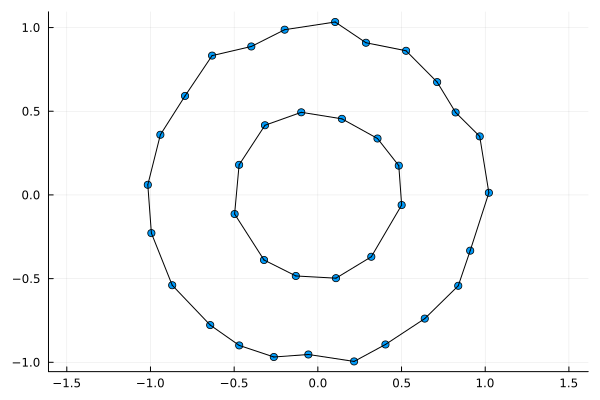

In [210]:
graphplot(points, points_covered_by_landmarks)